In [1]:
#follow Visium Fluoresence tutorial for PA12 analysis, follow Visium H&E tutorial for PA04 analysis

#fluoresence first
# (also i should find out what is cytassist lowkey)

import pandas as pd
import matplotlib.pyplot as plt
import anndata as ad
import scanpy as sc
import squidpy as sq
import numpy as np

sc.logging.print_header()
print(f"squidpy=={sq.__version__}")
#importing the spatial data using read_visium 
adata_PA12 = sc.read_visium("spatial_data", load_images=True)
#SPATIAL_DATA CONTAINS PATIENT 12 DATA

# #get the tissue image and the spatial coordinates csv

# coords = pd.read_csv("spatial_data/spatial/tissue_positions_list.csv", header=None, index_col=0)
# coords = coords.loc[adata_PA12.obs_names] #order the coords in the same way as adata object
# # coords.head()
# adata_PA12.obsm["spatial"] = coords

# adata_PA12.obs

/Users/anushkadole/PDAC-scRNA/.venv/lib/python3.9/site-packages/numba/core/decorators.py:246: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)


scanpy==1.10.3 anndata==0.10.8 umap==0.5.9.post2 numpy==1.26.4 scipy==1.13.1 pandas==2.3.2 scikit-learn==1.6.1 statsmodels==0.14.5 igraph==0.11.9 pynndescent==0.5.13
squidpy==1.6.1


/Users/anushkadole/PDAC-scRNA/.venv/lib/python3.9/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Users/anushkadole/PDAC-scRNA/.venv/lib/python3.9/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [2]:
#standard scanpy clustering and umap workflow
sc.pp.normalize_total(adata_PA12)
sc.pp.log1p(adata_PA12)
sc.pp.pca(adata_PA12)
sc.pp.neighbors(adata_PA12)
sc.tl.umap(adata_PA12)
sc.tl.leiden(adata_PA12)
adata_PA12

/var/folders/lq/975sjw597cx0pdrngj4hf1tr0000gn/T/ipykernel_92120/3340358157.py:7: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata_PA12)


AnnData object with n_obs × n_vars = 4855 × 18085
    obs: 'in_tissue', 'array_row', 'array_col', 'leiden'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial', 'log1p', 'pca', 'neighbors', 'umap', 'leiden'
    obsm: 'spatial', 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

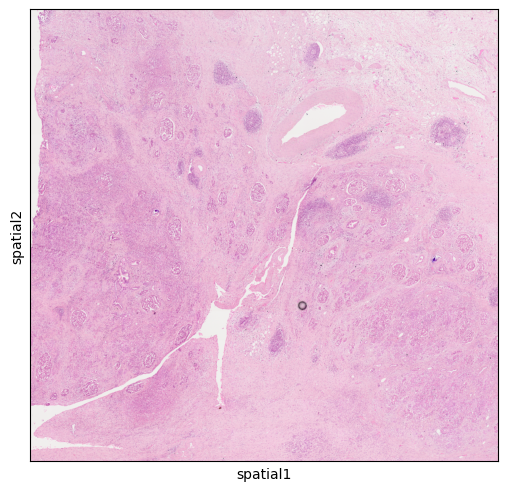

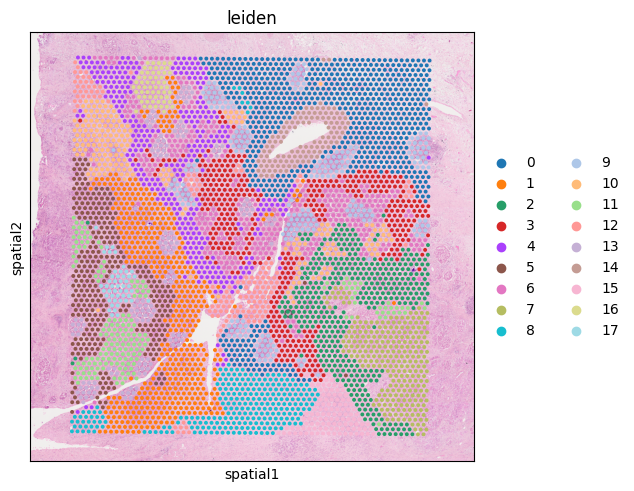

In [3]:
#seeing if it actually worked
sq.pl.spatial_scatter(adata_PA12, size=1)
sq.pl.spatial_scatter(adata_PA12, color="leiden", size=1)

In [4]:
import json
img_path = "spatial_data/spatial/tissue_hires_image.png"
img = sq.im.ImageContainer(img_path)
with open("spatial_data/spatial/scalefactors_json.json") as f:
    sf = json.load(f)
scl = sf["tissue_hires_scalef"]
adata_PA12.obsm["spatial"] = adata_PA12.obsm["spatial"].copy() * scl
#scaling the coordinates to match the highres image

# calculate features for different scales (higher value means more context)
for scale in [1.0, 2.0]:
    feature_name = f"features_summary_scale{scale}"
    sq.im.calculate_image_features(
        adata_PA12,
        img.compute(),
        features="summary",
        key_added=feature_name,
        n_jobs=4,
        scale=scale,
    )


# combine features in one dataframe
adata_PA12.obsm["features"] = pd.concat(
    [adata_PA12.obsm[f] for f in adata_PA12.obsm.keys() if "features_summary" in f],
    axis="columns",
)
# make sure that we have no duplicated feature names in the combined table
adata_PA12.obsm["features"].columns = ad.utils.make_index_unique(
    adata_PA12.obsm["features"].columns
)

  0%|          | 0/4855 [00:00<?, ?/s]

/Users/anushkadole/PDAC-scRNA/.venv/lib/python3.9/site-packages/numba/core/decorators.py:246: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)
/Users/anushkadole/PDAC-scRNA/.venv/lib/python3.9/site-packages/numba/core/decorators.py:246: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)
/Users/anushkadole/PDAC-scRNA/.venv/lib/python3.9/site-packages/numba/core/decorators.py:246: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)
/Users/anushkadole/PDAC-scRNA/.venv/lib/python3.9/site-packages/numba/core/decorators.py:246: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)
/Users/anushkadole/PDAC-scRNA/.venv/lib/python3.9/site-packages/numba/core/decorators.py:246: Runtim

  0%|          | 0/4855 [00:00<?, ?/s]

/Users/anushkadole/PDAC-scRNA/.venv/lib/python3.9/site-packages/numba/core/decorators.py:246: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)


In [5]:
adata_PA12.obsm["features"].head()


,summary_ch-0_quantile-0.9,summary_ch-0_quantile-0.5,summary_ch-0_quantile-0.1,summary_ch-0_mean,summary_ch-0_std,summary_ch-1_quantile-0.9,summary_ch-1_quantile-0.5,summary_ch-1_quantile-0.1,summary_ch-1_mean,summary_ch-1_std,...,summary_ch-1_quantile-0.9-1,summary_ch-1_quantile-0.5-1,summary_ch-1_quantile-0.1-1,summary_ch-1_mean-1,summary_ch-1_std-1,summary_ch-2_quantile-0.9-1,summary_ch-2_quantile-0.5-1,summary_ch-2_quantile-0.1-1,summary_ch-2_mean-1,summary_ch-2_std-1
AACACCTACTATCGAA-1,241.0,235.0,219.0,226.401574,38.855313,209.0,190.0,157.0,182.800480,36.171616,...,205.0,190.0,160.0,182.343286,34.471055,224.0,217.0,206.0,210.513666,35.317969
AACACGTGCATCGCAC-1,236.0,230.0,212.0,226.505955,11.246661,206.0,184.0,151.0,181.300413,22.774817,...,202.0,183.0,155.0,180.831726,19.057257,221.0,212.0,200.0,210.920529,8.932413
AACACTTGGCAAGGAA-1,240.0,234.0,211.0,229.420685,13.860896,209.0,188.0,145.0,182.700288,27.725306,...,205.0,187.0,148.0,182.230852,24.813823,223.0,214.0,196.0,211.640580,11.571452
AACAGGAAGAGCATAG-1,236.0,231.0,217.0,228.559026,10.243652,204.0,187.0,162.0,184.927192,18.702743,...,200.0,186.0,165.0,184.457790,15.678892,220.0,213.0,203.0,211.985324,7.753354
AACAGGATTCATAGTT-1,239.0,233.0,210.0,228.054158,13.768631,206.0,185.0,146.0,180.596249,25.344038,...,202.0,184.0,151.0,180.127421,21.688276,221.0,213.0,198.0,211.027038,10.288954


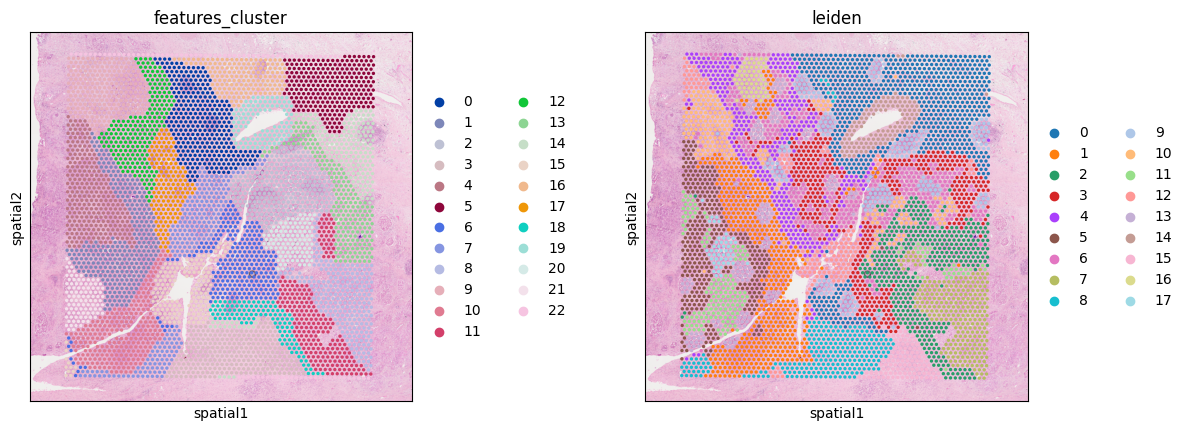

In [12]:
# helper function returning a clustering
def cluster_features(features: pd.DataFrame, like=None) -> pd.Series:
    #like is a string to filter the features
    """
    Calculate leiden clustering of features.

    Specify filter of features using `like`.
    """
    # filter features
    if like is not None:
        features = features.filter(like=like)
    # create temporary adata to calculate the clustering
    adata = ad.AnnData(features)
    # important - feature values are not scaled, so need to scale them before PCA
    sc.pp.scale(adata)
    # calculate leiden clustering
    sc.pp.pca(adata, n_comps=min(15, features.shape[1] - 1))
    sc.pp.neighbors(adata, n_pcs=15)
    sc.tl.leiden(adata, resolution=0.4)

    return adata.obs["leiden"]

# calculate feature clusters
adata_PA12.obs["features_cluster"] = cluster_features(adata_PA12.obsm["features"], like="summary")

# compare feature and gene clusters
sq.pl.spatial_scatter(adata_PA12, color=["features_cluster", "leiden"])